<h1 style="text-align: center; font-weight: bold;">Initiation à l'Inverse Reinforcement Learning</h1>
<h3 style="text-align: center; color: gray;">Premier cas d'application : robot à deux axes</h3>

In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

## **Étude théorique**

On a cette fois-ci un système de "bras" à deux axes. Voici les équations de projection du système :

Pour le repère $\mathcal{R_1}$ :

\begin{align*}
\mathbf{x_1} = & \begin{bmatrix} \cos q_1(t) \\ \sin q_1(t) \end{bmatrix}_{\mathcal{R}_0}
\end{align*}

\begin{align*}
\mathbf{y_1} = & \begin{bmatrix} - \sin q_1(t) \\ \cos q_1(t) \end{bmatrix}_{\mathcal{R}_0}
\end{align*}


Pour le repère $\mathcal{R_2}$ :

\begin{align*}
\mathbf{x_2} = & \begin{bmatrix} \cos \displaystyle\left[ q_1(t) + q_2(t) \right] \\ \sin \displaystyle\left[ q_1(t) + q_2(t) \right] \end{bmatrix}_{\mathcal{R}_0}
\end{align*}

\begin{align*}
\mathbf{y_2} = & \begin{bmatrix} - \sin \displaystyle\left[ q_1(t) + q_2(t) \right] \\ \cos \displaystyle\left[ q_1(t) + q_2(t) \right] \end{bmatrix}_{\mathcal{R}_0}
\end{align*}

<!-- écriture en ligne d'un vecteur dans un repère R_0 -->


On peut ainsi réécrire la position de l'effecteur (bout du bras) :

\begin{align*}
\mathbf{P(t)} = & L_1 \mathbf{x_1} + L_2 \mathbf{x_2} = \begin{bmatrix} L_1\cos q_1(t) + L_2 \cos \displaystyle\left[ q_1(t) + q_2(t) \right] \\ L_1 \sin q_1(t) + L_2 \sin \displaystyle\left[ q_1(t) + q_2(t) \right] \end{bmatrix}_{\mathcal{R}_0}
\end{align*}

La Jacobienne de $\mathbf{P(t)}$ peut ainsi être développée de la manière suivante :

\begin{align*}
\mathbf{\mathcal{J}_{P(t)}} = \begin{bmatrix} \cfrac{\partial P_x}{ \partial x} & \cfrac{\partial P_x}{\partial y} \\ \cfrac{\partial P_y}{ \partial x} & \cfrac{\partial P_y}{\partial y} \end{bmatrix}_{\mathcal{R}_0}
\end{align*}


On cherche à résoudre le problème d'optimisation suivant :

$$
\argmin\limits_{q,\dot{q} \in \mathbb{R}^{2 \times 10}} \sum\limits_{i = 1}^{10} w_{0i} \dot{q_0}_i^2 + w_{1i} \dot{q_1}_i^2 + w_{2i} \lVert \partial P_{x_{t_i}} \rVert^2
$$

sous contraintes :

\begin{align*}
\forall t \in \llbracket 2, 10 \rrbracket, q(t) = q(t - 1) + \dot{q}(t) dt \\
q(0) = (q_1(0), q_2(0)) = (0, \pi/2) \\
P_x(t_f) = P_{x_d} = -0.75
\end{align*}

In [2]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 10  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((N_angles, N))
w_2 = DM.ones(N)

# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# \Phi_2 : coût sur la vitesse linéaire en abscisse
J_2 = 0

for t in range(N):
    # q1_t = q[0, t]
    # q2_t = q[1, t]
    # J_2 +=  w_2[t] * (L_1*sin(q1_t) + L_2*(cos(q2_t)*sin(q1_t) + sin(q2_t)*cos(q1_t)))**2 + (L_2*(cos(q1_t)*sin(q2_t) + sin(q1_t)*cos(q2_t)))**2
    J_2 +=  w_2[t] * ((L_1*sin(q[0, t]) + L_2*(cos(q[1, t])*sin(q[0, t]) + sin(q[1, t])*cos(q[0, t])))**2 + (L_2*(cos(q[0, t])*sin(q[1, t]) + sin(q[0, t])*cos(q[1, t])))**2)
# J_2 = w[1, :] * Phi_2**2

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi/2])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       58
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality c

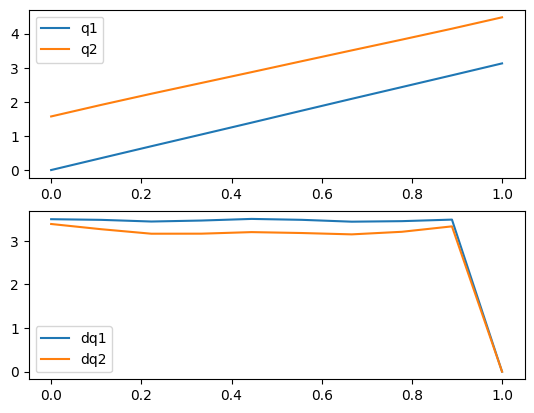

In [3]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(t_0, t_f, N), q1, label='q1')
plt.plot(np.linspace(t_0, t_f, N), q2, label='q2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(t_0, t_f, N), dq1, label='dq1')
plt.plot(np.linspace(t_0, t_f, N), dq2, label='dq2')
plt.legend()
plt.show()

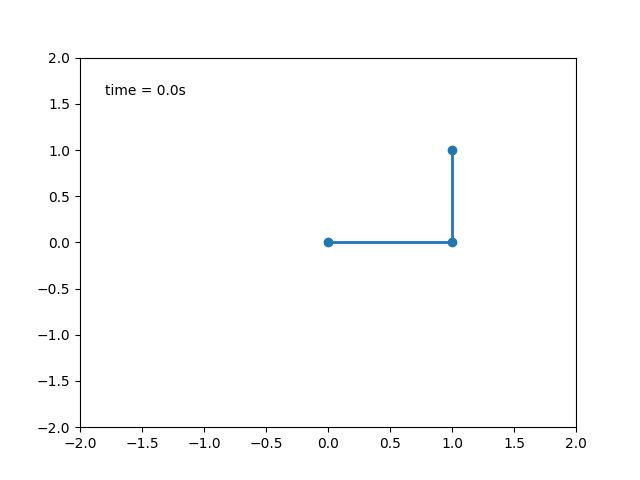

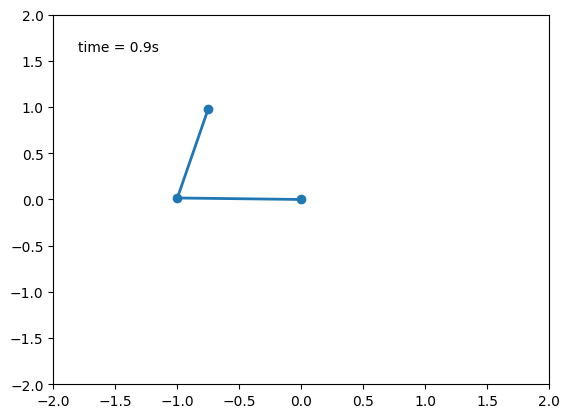

In [4]:
# Animation du robot

# Import des librairies pour générer le gif, et création du gif

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
L1 = 1
L2 = 1
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text
def animate(i):
    thisx = [0, L1*cos(q1[i]), L1*cos(q1[i]) + L2*cos(q1[i] + q2[i])]
    thisy = [0, L1*sin(q1[i]), L1*sin(q1[i]) + L2*sin(q1[i] + q2[i])]
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text
ani = animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=True, init_func=init)
writergif = PillowWriter(fps=N)
ani.save('robot_arm.gif', writer=writergif)

# affichage du gif
from IPython.display import Image
Image(open('robot_arm.gif','rb').read())

<>:40: SyntaxWarning: invalid escape sequence '\P'
<>:40: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_28867/229399103.py:40: SyntaxWarning: invalid escape sequence '\P'
  ax.set_title('Coût pour $\Phi_2 = (\partial P_x / \partial (x,y))^2$')


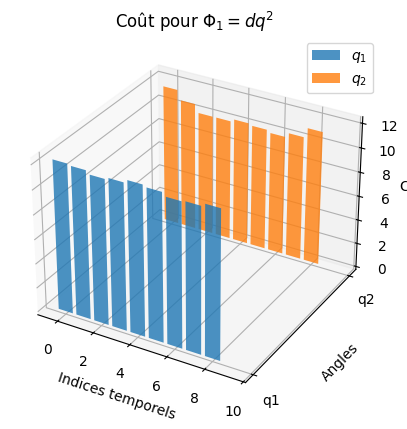

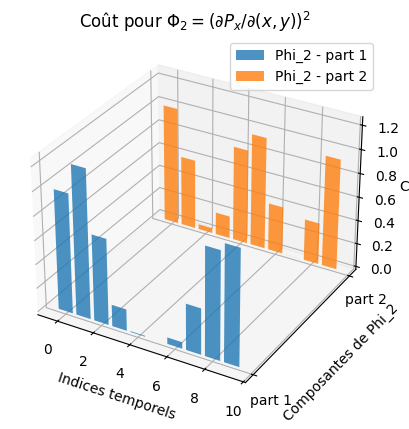

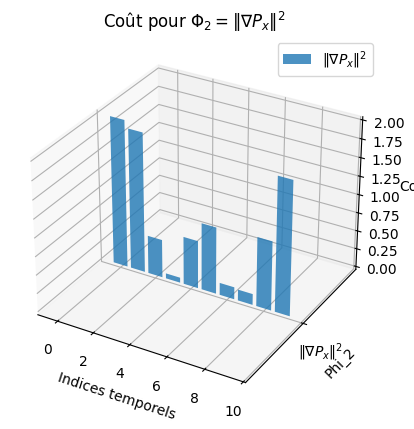

In [5]:
# calcul des coûts pour la trajectoire optimale

Phi_1_opti = np.zeros((2,N))
Phi_1_opti[0,:] = dq1**2
Phi_1_opti[1,:] = dq2**2

Phi_2_opti = np.zeros((2,N))
Phi_2_opti[0,:] = (L_1*np.sin(q1) + L_2*(np.cos(q2)*np.sin(q1) + np.sin(q2)*np.cos(q1)))**2
Phi_2_opti[1,:] = (L_2*(np.cos(q1)*np.sin(q2) + np.sin(q1)*np.cos(q2)))**2


# affichage des coûts sous forme de barres empilées 3D, affichés sur deux figures différentes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
y1 = Phi_1_opti[0,:]
y2 = Phi_1_opti[1,:]
ax.bar(x, y1, zs=0, zdir='y', alpha=0.8, label='$q_1$')
ax.bar(x, y2, zs=1, zdir='y', alpha=0.8, label='$q_2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Angles')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels(['q1', 'q2'])
ax.set_title(r'Coût pour $\Phi_1 = dq^2$')
ax.legend()
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
y1 = Phi_2_opti[0,:]
y2 = Phi_2_opti[1,:]
ax.bar(x, y1, zs=0, zdir='y', alpha=0.8, label='Phi_2 - part 1')
ax.bar(x, y2, zs=1, zdir='y', alpha=0.8, label='Phi_2 - part 2')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Composantes de Phi_2')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels(['part 1', 'part 2'])
ax.set_title('Coût pour $\Phi_2 = (\partial P_x / \partial (x,y))^2$')
ax.legend()
plt.show()


# Affichage Phi_2 global
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
ax.bar(x, Phi_2_opti[0,:]**2 + Phi_2_opti[1,:]**2, zs=0, zdir='y', alpha=0.8, label=r'$\|\nabla P_x\|^2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Phi_2')
ax.set_zlabel('Coût')
ax.set_yticks([0])
ax.set_yticklabels([r'$\|\nabla P_x\|^2$'])
ax.set_title(r'Coût pour $\Phi_2 = \|\nabla P_x\|^2$')
ax.legend()
plt.show()

## **Simulation avec les gradients calculés avec casadi**

In [6]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 10  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((N_angles, N))
w_2 = DM.ones(N)

# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = MX.sym("q", 2)

# Px et gradient
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
grad_Px = gradient(Px, q_sym)
dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])

# Fonction pour dPx^2
# def dPx_sq_func(q_t0, q_t1):
#     # q_t0 = q[0, t], q_t1 = q[1, t] (des MX)
#     q_vec = vertcat(q_t0, q_t1)  # vecteur symbolique correct
#     Px = L_1*cos(q_vec[0]) + L_2*cos(q_vec[0] + q_vec[1])
#     grad_Px = gradient(Px, q_vec)
#     return dot(grad_Px, grad_Px)

# Coût J2 avec la norme du gradient
J_2 = 0
for t in range(N):
    q_t = vertcat(q[0, t], q[1, t])  # vecteur symbolique “slice” valide
    J_2 += w_2[t] * dPx_sq_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi/2])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       58
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

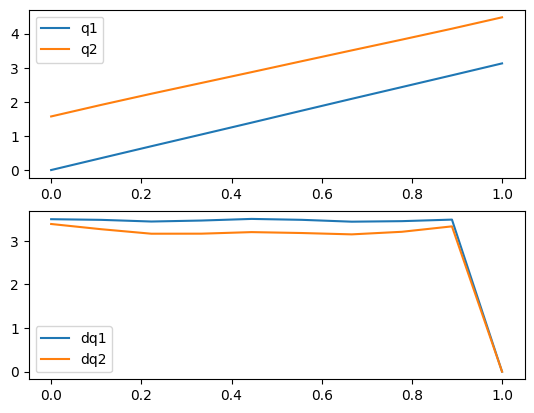

In [7]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(t_0, t_f, N), q1, label='q1')
plt.plot(np.linspace(t_0, t_f, N), q2, label='q2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(t_0, t_f, N), dq1, label='dq1')
plt.plot(np.linspace(t_0, t_f, N), dq2, label='dq2')
plt.legend()
plt.show()

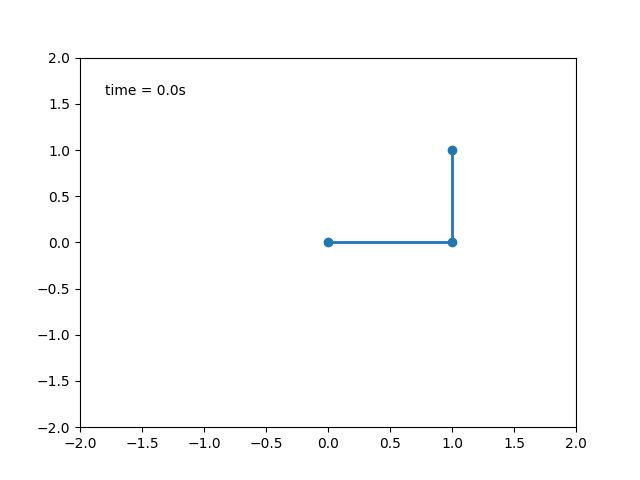

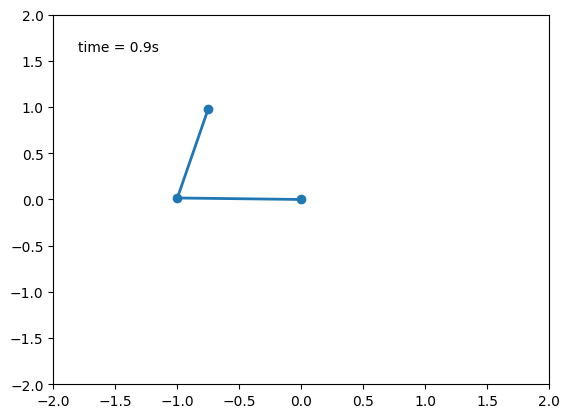

In [8]:
# Animation du robot

# Import des librairies pour générer le gif, et création du gif

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text
def animate(i):
    thisx = [0, L_1*cos(q1[i]), L_1*cos(q1[i]) + L_2*cos(q1[i] + q2[i])]
    thisy = [0, L_1*sin(q1[i]), L_1*sin(q1[i]) + L_2*sin(q1[i] + q2[i])]
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text
ani = animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=True, init_func=init)
writergif = PillowWriter(fps=N)
ani.save('robot_arm.gif', writer=writergif)

# affichage du gif
from IPython.display import Image
Image(open('robot_arm.gif','rb').read())

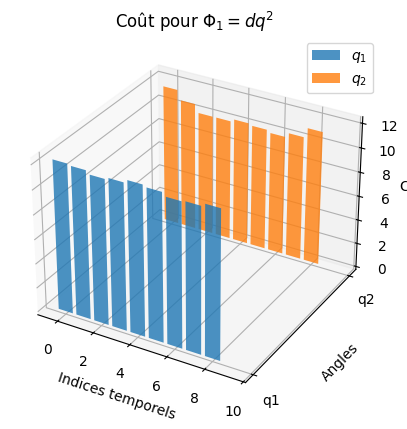

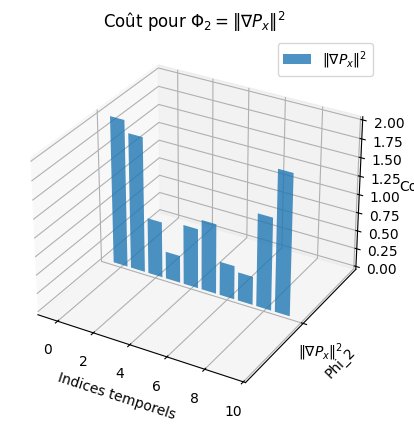

In [9]:
# -------------------------
# Calcul des coûts optimaux
# -------------------------

# Phi_1 = dq^2
Phi_1_opti = np.zeros((2, N))
Phi_1_opti[0, :] = dq1**2
Phi_1_opti[1, :] = dq2**2

# Phi_2 = ||grad Px||^2
Phi_2_opti = np.zeros(N)
for t in range(N):
    dPx_dq1 = -L_1*np.sin(q1[t]) - L_2*np.sin(q1[t] + q2[t])
    dPx_dq2 = -L_2*np.sin(q1[t] + q2[t])
    Phi_2_opti[t] = dPx_dq1**2 + dPx_dq2**2

# -------------------------
# Affichage des coûts
# -------------------------

# Affichage Phi_1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
y1 = Phi_1_opti[0, :]
y2 = Phi_1_opti[1, :]
ax.bar(x, y1, zs=0, zdir='y', alpha=0.8, label='$q_1$')
ax.bar(x, y2, zs=1, zdir='y', alpha=0.8, label='$q_2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Angles')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels(['q1', 'q2'])
ax.set_title(r'Coût pour $\Phi_1 = dq^2$')
ax.legend()
plt.show()

# Affichage Phi_2 global
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
ax.bar(x, Phi_2_opti, zs=0, zdir='y', alpha=0.8, label=r'$\|\nabla P_x\|^2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Phi_2')
ax.set_zlabel('Coût')
ax.set_yticks([0])
ax.set_yticklabels([r'$\|\nabla P_x\|^2$'])
ax.set_title(r'Coût pour $\Phi_2 = \|\nabla P_x\|^2$')
ax.legend()
plt.show()

## **Ajout de la minimisation de $\lVert \nabla P_y \rVert^2$**

In [ ]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 100  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((N_angles, N))
w_2 = DM.zeros(N)
w_3 = DM.ones(N)

# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = MX.sym("q", 2)

# Px et gradient
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
grad_Px = gradient(Px, q_sym)
dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])


# Py
Py = L_1*sin(q_sym[0]) + L_2*sin(q_sym[0] + q_sym[1])
grad_Py = gradient(Py, q_sym)
dPy_sq_fun = Function("dPy_sq", [q_sym], [dot(grad_Py, grad_Py)])

J_2 = 0
J_3 = 0
for t in range(N):
    q_t = vertcat(q[0, t], q[1, t])
    J_2 += w_2[t] * dPx_sq_fun(q_t)
    J_3 += w_3[t] * dPy_sq_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi/2])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      598
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      500

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0000000e+02 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

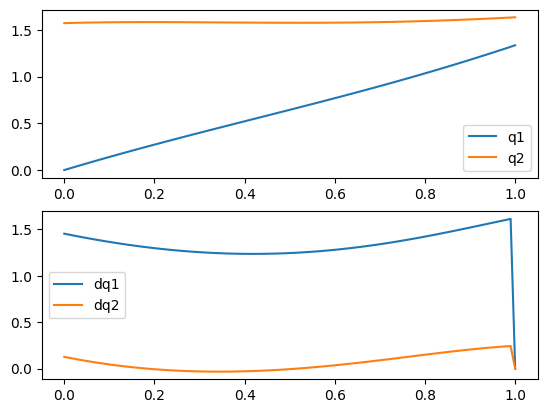

In [67]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(t_0, t_f, N), q1, label='q1')
plt.plot(np.linspace(t_0, t_f, N), q2, label='q2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(t_0, t_f, N), dq1, label='dq1')
plt.plot(np.linspace(t_0, t_f, N), dq2, label='dq2')
plt.legend()
plt.show()

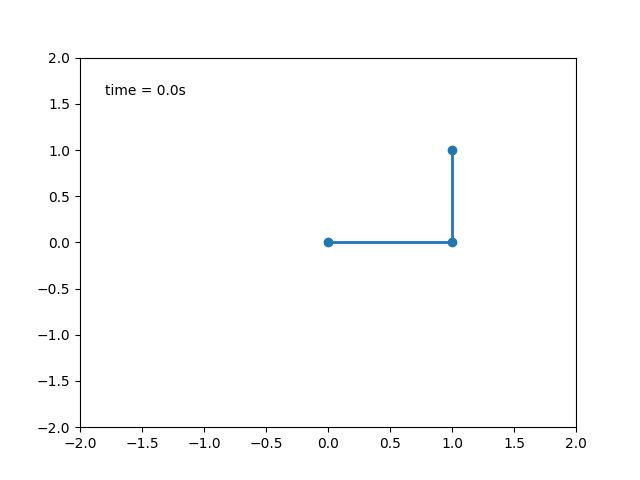

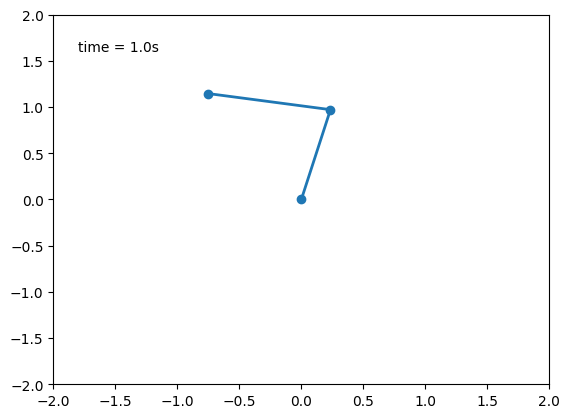

In [68]:
# Animation du robot

# Import des librairies pour générer le gif, et création du gif

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text
def animate(i):
    thisx = [0, L_1*cos(q1[i]), L_1*cos(q1[i]) + L_2*cos(q1[i] + q2[i])]
    thisy = [0, L_1*sin(q1[i]), L_1*sin(q1[i]) + L_2*sin(q1[i] + q2[i])]
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text
ani = animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=True, init_func=init)
writergif = PillowWriter(fps=20)
ani.save('robot_arm.gif', writer=writergif)

# affichage du gif
from IPython.display import Image
Image(open('robot_arm.gif','rb').read())

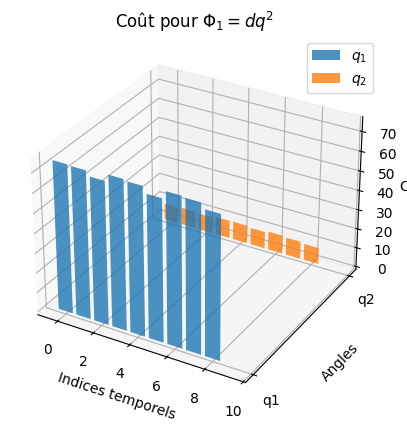

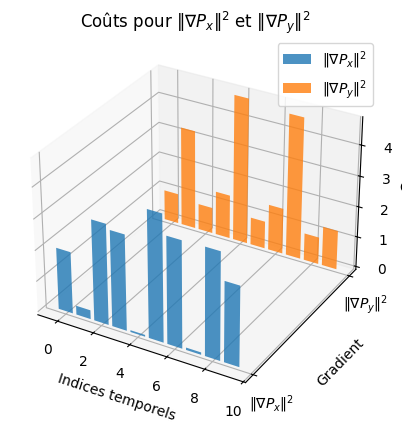

In [24]:
# -------------------------
# Variables symboliques
# -------------------------
q_sym = MX.sym("q", 2)

# Px et Py
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
Py = L_1*sin(q_sym[0]) + L_2*sin(q_sym[0] + q_sym[1])

# Gradients et fonctions CasADi
grad_Px = gradient(Px, q_sym)
grad_Py = gradient(Py, q_sym)

dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])
dPy_sq_fun = Function("dPy_sq", [q_sym], [dot(grad_Py, grad_Py)])

# -------------------------
# Calcul des coûts optimaux
# -------------------------
Phi_1_opti = np.zeros((2, N))
Phi_1_opti[0, :] = dq1**2
Phi_1_opti[1, :] = dq2**2

Phi_2_opti = np.zeros(N)
Phi_3_opti = np.zeros(N)

for t in range(N):
    q_t = np.array([q1[t], q2[t]])
    Phi_2_opti[t] = dPx_sq_fun(q_t).full().item()  # évaluer la fonction CasADi
    Phi_3_opti[t] = dPy_sq_fun(q_t).full().item()

# -------------------------
# Affichage Phi_1
# -------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
y1 = Phi_1_opti[0, :]
y2 = Phi_1_opti[1, :]
ax.bar(x, y1, zs=0, zdir='y', alpha=0.8, label='$q_1$')
ax.bar(x, y2, zs=1, zdir='y', alpha=0.8, label='$q_2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Angles')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels(['q1', 'q2'])
ax.set_title(r'Coût pour $\Phi_1 = dq^2$')
ax.legend()
plt.show()

# -------------------------
# Affichage Phi_2 et Phi_3
# -------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
ax.bar(x, Phi_2_opti, zs=0, zdir='y', alpha=0.8, label=r'$\|\nabla P_x\|^2$')
ax.bar(x, Phi_3_opti, zs=1, zdir='y', alpha=0.8, label=r'$\|\nabla P_y\|^2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Gradient')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels([r'$\|\nabla P_x\|^2$', r'$\|\nabla P_y\|^2$'])
ax.set_title(r'Coûts pour $\|\nabla P_x\|^2$ et $\|\nabla P_y\|^2$')
ax.legend()
plt.show()

## **Ajout de la manipulabilité dans la fonction coût $\det(JJ^{\mathrm{T}})$**

In [214]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 10  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((N_angles, N))
w_2 = DM.ones(N)
w_3 = DM.ones(N)
w_4 = DM.ones(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = MX.sym("q", 2)

# Px et gradient
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
grad_Px = gradient(Px, q_sym)
dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])


# Py et gradient
Py = L_1*sin(q_sym[0]) + L_2*sin(q_sym[0] + q_sym[1])
grad_Py = gradient(Py, q_sym)
dPy_sq_fun = Function("dPy_sq", [q_sym], [dot(grad_Py, grad_Py)])

# Manipulabilité det(JJ^T)
# Variables symboliques dans R^2
# x = SX.sym('x', 2)


q_sym2 = SX.sym("q", 2)

# f et Jacobien
f = vertcat(L_1*cos(q_sym2[0]) + L_2*cos(q_sym2[0] + q_sym2[1]),
            L_1*sin(q_sym2[0]) + L_2*sin(q_sym2[0] + q_sym2[1]))
J = jacobian(f, q_sym2)
JJt = J @ J.T
eps = 1e-6
# NOTE : j'avais tenté une autre approche pour le coût suivant, mais on m'a dit de l'abandonner
# log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(fabs(det(JJt) - 1))])
log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(det(JJt) + eps)])
JJt_fun = Function("JJt", [q_sym2], [JJt])

J_2 = 0
J_3 = 0
J_4 = 0
for t in range(N):
    q_t = vertcat(q[0, t], q[1, t])
    J_2 += w_2[t] * dPx_sq_fun(q_t)
    J_3 += w_3[t] * dPy_sq_fun(q_t)
    J_4 += w_4[t] * log_det_JJt_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi/8])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       58
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8815511e+02 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

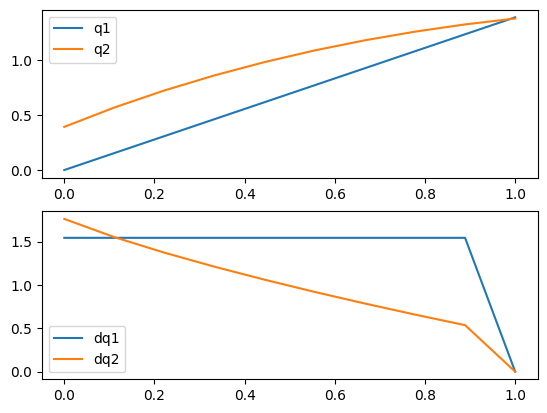

In [215]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(t_0, t_f, N), q1, label='q1')
plt.plot(np.linspace(t_0, t_f, N), q2, label='q2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(t_0, t_f, N), dq1, label='dq1')
plt.plot(np.linspace(t_0, t_f, N), dq2, label='dq2')
plt.legend()
plt.show()

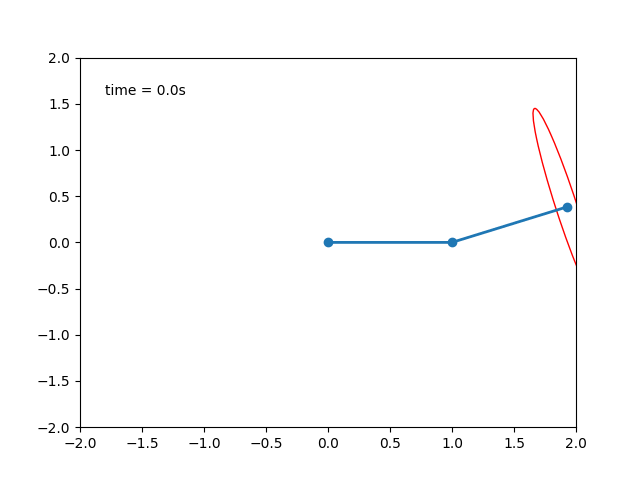

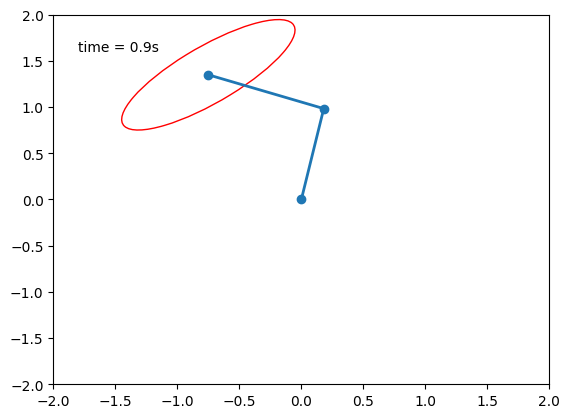

In [216]:
# Animation du robot

# Import des librairies pour générer le gif, et création du gif

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Création de l’ellipse (taille arbitraire 0.2 x 0.1)
manipulabilite = JJt_fun(vertcat(q1[0], q2[0])).full()
vals, vecs = np.linalg.eig(manipulabilite)
# calcul des axes de l’ellipse
width = np.sqrt(vals[0])
height = np.sqrt(vals[1])
# angle de l’ellipse (orthogonal au deuxième segment du robot)

# angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
# création de l’ellipse
ellipse = Ellipse((0, L_1*cos(q1[0]), L_1*cos(q1[0]) + L_2*cos(q1[0] + q2[0])), width=width, height=height, angle=angle, fill=False, color="red")
ax.add_patch(ellipse)


# Fonction pour calculer la manipulabilité


def init():
    line.set_data([], [])
    time_text.set_text('')

    ellipse.set_center((0, L_1*cos(q1[0]), L_1*cos(q1[0]) + L_2*cos(q1[0] + q2[0])))  # on la place à l'origine au départ

    return line, time_text

def animate(i):
    thisx = [0, L_1*cos(q1[i]), L_1*cos(q1[i]) + L_2*cos(q1[i] + q2[i])]
    thisy = [0, L_1*sin(q1[i]), L_1*sin(q1[i]) + L_2*sin(q1[i] + q2[i])]
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    # mise à jour de l'ellipse au bout du bras
    ellipse.set_center((thisx[-1], thisy[-1]))
    manipulabilite = JJt_fun(vertcat(q1[i], q2[i])).full()
    vals, vecs = np.linalg.eig(manipulabilite)
    width = np.sqrt(vals[0])
    height = np.sqrt(vals[1])
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    ellipse.width = width
    ellipse.height = height
    ellipse.angle = angle

    return line, time_text

ani = animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=True, init_func=init)
writergif = PillowWriter(fps=20)
ani.save('robot_arm.gif', writer=writergif)

# affichage du gif
from IPython.display import Image
Image(open('robot_arm.gif','rb').read())

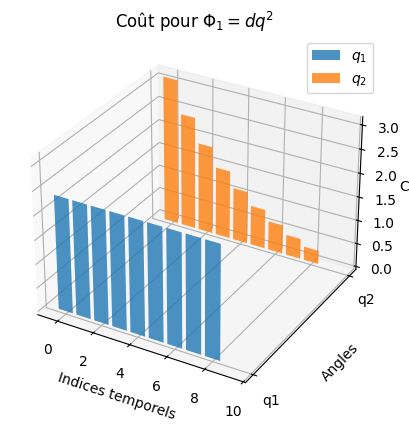

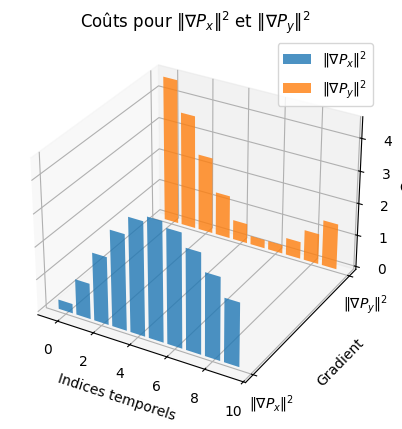

In [217]:
# -------------------------
# Variables symboliques
# -------------------------
q_sym = MX.sym("q", 2)

# Px et Py
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
Py = L_1*sin(q_sym[0]) + L_2*sin(q_sym[0] + q_sym[1])

# Gradients et fonctions CasADi
grad_Px = gradient(Px, q_sym)
grad_Py = gradient(Py, q_sym)

dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])
dPy_sq_fun = Function("dPy_sq", [q_sym], [dot(grad_Py, grad_Py)])

# Jacobien et ellipsoïde
P = vertcat(Px, Py)
J = jacobian(P, q_sym)
JJt_fun = Function("JJt", [q_sym], [J @ J.T])

# -------------------------
# Calcul des coûts optimaux
# -------------------------
Phi_1_opti = np.zeros((2, N))
Phi_1_opti[0, :] = dq1**2
Phi_1_opti[1, :] = dq2**2

Phi_2_opti = np.zeros(N)
Phi_3_opti = np.zeros(N)

for t in range(N):
    q_t = np.array([q1[t], q2[t]], dtype=float).reshape((2,1))
    Phi_2_opti[t] = dPx_sq_fun(q_t).full().item()
    Phi_3_opti[t] = dPy_sq_fun(q_t).full().item()

# -------------------------
# Affichage Phi_1
# -------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
y1 = Phi_1_opti[0, :]
y2 = Phi_1_opti[1, :]
ax.bar(x, y1, zs=0, zdir='y', alpha=0.8, label='$q_1$')
ax.bar(x, y2, zs=1, zdir='y', alpha=0.8, label='$q_2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Angles')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels(['q1', 'q2'])
ax.set_title(r'Coût pour $\Phi_1 = dq^2$')
ax.legend()
plt.show()

# -------------------------
# Affichage Phi_2 et Phi_3
# -------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(N)
ax.bar(x, Phi_2_opti, zs=0, zdir='y', alpha=0.8, label=r'$\|\nabla P_x\|^2$')
ax.bar(x, Phi_3_opti, zs=1, zdir='y', alpha=0.8, label=r'$\|\nabla P_y\|^2$')
ax.set_xlabel('Indices temporels')
ax.set_ylabel('Gradient')
ax.set_zlabel('Coût')
ax.set_yticks([0, 1])
ax.set_yticklabels([r'$\|\nabla P_x\|^2$', r'$\|\nabla P_y\|^2$'])
ax.set_title(r'Coûts pour $\|\nabla P_x\|^2$ et $\|\nabla P_y\|^2$')
ax.legend()
plt.show()

## **Inverse Reinforcement Learning**

### **Démarche**

Pour pouvoir faire du MaxEnt Inverse Reinforcement Learning, on va avoir besoin de l'expression d'une approximation de l'espérance réelle de notre coût (suivant la statistique de Boltzmann). Pour ce faire, à partir de notre trajectoire optimale, on va générer des trajectoires bruitées en bruitant les $dq$ puis en intégrant pour obtenir $q$.

Dans un premier temps, on remets le code de la résolution (dans le dernier cas, avec tous les coûts dont la manipulabilité).

In [218]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 10  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((N_angles, N))
w_2 = DM.ones(N)
w_3 = DM.ones(N)
w_4 = DM.ones(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = MX.sym("q", 2)

# Px et gradient
Px = L_1*cos(q_sym[0]) + L_2*cos(q_sym[0] + q_sym[1])
grad_Px = gradient(Px, q_sym)
dPx_sq_fun = Function("dPx_sq", [q_sym], [dot(grad_Px, grad_Px)])


# Py et gradient
Py = L_1*sin(q_sym[0]) + L_2*sin(q_sym[0] + q_sym[1])
grad_Py = gradient(Py, q_sym)
dPy_sq_fun = Function("dPy_sq", [q_sym], [dot(grad_Py, grad_Py)])

# Manipulabilité det(JJ^T)
# Variables symboliques dans R^2
# x = SX.sym('x', 2)


q_sym2 = SX.sym("q", 2)

# f et Jacobien
f = vertcat(L_1*cos(q_sym2[0]) + L_2*cos(q_sym2[0] + q_sym2[1]),
            L_1*sin(q_sym2[0]) + L_2*sin(q_sym2[0] + q_sym2[1]))
J = jacobian(f, q_sym2)
JJt = J @ J.T
eps = 1e-6
# NOTE : j'avais tenté une autre approche pour le coût suivant, mais on m'a dit de l'abandonner
# log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(fabs(det(JJt) - 1))])
log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(det(JJt) + eps)])
JJt_fun = Function("JJt", [q_sym2], [JJt])

J_2 = 0
J_3 = 0
J_4 = 0
for t in range(N):
    q_t = vertcat(q[0, t], q[1, t])
    J_2 += w_2[t] * dPx_sq_fun(q_t)
    J_3 += w_3[t] * dPy_sq_fun(q_t)
    J_4 += w_4[t] * log_det_JJt_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi/8])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       58
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8815511e+02 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Une fois le système résolu, on a notre trajectoire optimale $((q_0, q_1), (dq_0, dq_1)) \in \mathbb{R}^{4 \times N_t}$. On garde le coût de l'expert.

In [219]:
# coût de la trajectoire experte
# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = horzcat(q1, q2)**2
J_1_expert = w_1[0,:] @ Phi_1[:,0] + w_1[1,:] @ Phi_1[:,0]

# autres coûrs : dP_x, dP_y et manipulabilité
J_2_expert = 0
J_3_expert = 0
J_4_expert = 0
for t in range(N):
    q_t = vertcat(q1[t], q2[t])
    J_2_expert += w_2[t] * dPx_sq_fun(q_t)
    J_3_expert += w_3[t] * dPy_sq_fun(q_t)
    J_4_expert += w_4[t] * log_det_JJt_fun(q_t)

J_expert = J_1_expert + J_2_expert + J_3_expert + J_4_expert

In [220]:
J_expert

DM(59.6979)

In [221]:
# nombre de trajectoires bruitées
n_traj = 500
sigma_bruit = 0.1

q1_traj = np.zeros((n_traj, N))
q2_traj = np.zeros((n_traj, N))
dq1_traj = np.zeros((n_traj, N))
dq2_traj = np.zeros((n_traj, N))

for i in range(n_traj):
    bruit1 = np.random.normal(0, sigma_bruit, N)
    bruit2 = np.random.normal(0, sigma_bruit, N)
    dq1_traj[i, :] = dq1 + bruit1
    dq2_traj[i, :] = dq2 + bruit2
    q1_traj[i, 0] = 0
    q2_traj[i, 0] = pi/8
    for t in range(N-1):
        q1_traj[i, t+1] = q1_traj[i, t] + dt * dq1_traj[i, t]
        q2_traj[i, t+1] = q2_traj[i, t] + dt * dq2_traj[i, t]


# calcul des coûts pour chaque trajectoire bruitée
Phi_1_traj_part_1 = dq1_traj**2
Phi_1_traj_part_2 = dq2_traj**2
J_1_traj = w_1[0,:] @ Phi_1_traj_part_1.T + w_1[1,:] @ Phi_1_traj_part_2.T

# pour les autres fonctions coûts, j'ai besoin de redéfinit les fonctions dPx, dPy et manipulabilité en versions batchées


# autres coûrs : dP_x, dP_y et manipulabilité
J_2_traj = np.zeros(n_traj)
J_3_traj = np.zeros(n_traj)
J_4_traj = np.zeros(n_traj)

for i in range(n_traj):
    J2 = 0
    J3 = 0
    J4 = 0
    for t in range(N):
        q_t = [q1_traj[i, t], q2_traj[i, t]]
        J2 += w_2[t] * float(dPx_sq_fun(q_t))
        J3 += w_3[t] * float(dPy_sq_fun(q_t))
        J4 += w_4[t] * float(log_det_JJt_fun(q_t))
    J_2_traj[i] = J2
    J_3_traj[i] = J3
    J_4_traj[i] = J4

J_traj = J_1_traj.T + J_2_traj + J_3_traj + J_4_traj

# dans cet exercice, les J sont très grands, donc on doit faire une petite manipulation pour le calcul des probabilités

# "conversion" en probabilités
p_traj = np.exp(-J_traj + np.min(J_traj))  # on soustrait le minimum pour éviter les overflow
p_traj /= np.sum(p_traj)  # normalisation pour que la somme fasse 1

In [152]:
q1_traj.shape

(500, 100)

In [225]:
# paramètres de la simulation
np.random.seed(42)        
# w_true = np.array([0.3, 0.7])
# n_candidates = 500        # nombre d'échantillon pour l'ensemble "véritable" [0,2]x[0,2]
n_expert = 80             # nombre d'exemples experts D tirés selon la vraie distribution
# domain_low, domain_high = 0.0, 2.0

# construction de [0,2]x[0,2]
# S = np.random.uniform(domain_low, domain_high, size=(n_candidates, 2))

# fonction coût
# def cost_numpy(F, w):
#     c1 = F[:, 0]**2
#     c2 = (F[:, 1] - 1.0)**2
#     return w[0]*c1 + w[1]*c2

# distribution sur les échantillons de l'espace [0,2]x[0,2]
# candidates_costs_true = cost_numpy(S, w_true)
#unnorm = np.exp(-candidates_costs_true - np.max(-candidates_costs_true))  # soustraction pour stabilité
# unnorm = np.exp(-candidates_costs_true)
# proba = unnorm / unnorm.sum()

# tirer des échantillons experts (indices) selon p(s)
expert_indices = np.random.choice(n_traj, size=n_expert, replace=True, p=np.array(p_traj).flatten())
q1_exp = q1_traj[expert_indices, :]
q2_exp = q2_traj[expert_indices, :] 
dq1_exp = dq1_traj[expert_indices, :] 
dq2_exp = dq2_traj[expert_indices, :] 

# formulation CasADi pour retrouver w
opti_inv = Opti()
w11_inv = opti_inv.variable(N)
w12_inv = opti_inv.variable(N)
w2_inv = opti_inv.variable(N)
w3_inv = opti_inv.variable(N)
w4_inv = opti_inv.variable(N)

# contraintes
# opti.subject_to(w1 >= 0)
# opti.subject_to(w2 >= 0)
# opti_inv.subject_to(sum1(w11_inv) + sum1(w12_inv) + sum1(w2_inv) + sum(w3_inv) + sum1(w4_inv) == 5 * N)

# convertir ensembles en DM (pour vectorisation CasADi)
# S_DM = DM(S)   # shape (N,2)
# D_DM = DM(D)   # shape (M,2)
q1_exp_DM = DM(q1_exp)  # shape (n_expert, N)
q2_exp_DM = DM(q2_exp)  # shape (n_expert, N)
dq1_exp_DM = DM(dq1_exp)  # shape (n_expert, N)
dq2_exp_DM = DM(dq2_exp)  # shape (n_expert, N)

q1_traj_DM = DM(q1_traj)  # shape (n_traj, N)
q2_traj_DM = DM(q2_traj)  # shape (n_traj, N)
dq1_traj_DM = DM(dq1_traj)  # shape (n_traj, N)
dq2_traj_DM = DM(dq2_traj)  # shape (n_traj, N)

# calcul vectorisé des coûts pour tous les candidats S (symbolique en w1,w2)
# c_S = w1 * (S[:,0]^2) + w2 * (S[:,1]-1)^2
# \Phi_1 : coût sur les vitesses angulaires

# calcul des coûts pour chaque trajectoire bruitée
# Phi_1_traj_part_1 = dq1_traj**2
# Phi_1_traj_part_2 = dq2_traj**2
J_1_traj_opt_inv = w11_inv.T @ Phi_1_traj_part_1.T + w12_inv.T @ Phi_1_traj_part_2.T

# pour les autres fonctions coûts, j'ai besoin de redéfinit les fonctions dPx, dPy et manipulabilité en versions batchées


# autres coûrs : dP_x, dP_y et manipulabilité
J_2_traj_opt_inv = np.zeros(n_traj)
J_3_traj_opt_inv = np.zeros(n_traj)
J_4_traj_opt_inv = np.zeros(n_traj)

for i in range(n_traj):
    J2 = 0
    J3 = 0
    J4 = 0
    for t in range(N):
        q_t = [q1_traj[i, t], q2_traj[i, t]]
        J2 += w2_inv[t] * float(dPx_sq_fun(q_t))
        J3 += w3_inv[t] * float(dPy_sq_fun(q_t))
        J4 += w4_inv[t] * float(log_det_JJt_fun(q_t))
    J_2_traj_opt_inv[i] = float(J2)
    J_3_traj_opt_inv[i] = J3
    J_4_traj_opt_inv[i] = J4

J_traj_opt_inv = J_1_traj_opt_inv.T + J_2_traj_opt_inv + J_3_traj_opt_inv + J_4_traj_opt_inv


Phi_1_exp_part_1 = dq1_exp_DM**2
Phi_1_exp_part_2 = dq2_exp_DM**2
J_1_exp_opt_inv = w11_inv.T @ Phi_1_exp_part_1 + w12_inv.T @ Phi_1_exp_part_2

J_2_exp_opt_inv = np.zeros(n_traj)
J_3_exp_opt_inv = np.zeros(n_traj)
J_4_exp_opt_inv = np.zeros(n_traj)

for i in range(n_traj):
    J2 = 0
    J3 = 0
    J4 = 0
    for t in range(N):
        q_t = [q1_exp_DM[i, t], q2_exp_DM[i, t]]
        J2 += w2_inv[t] * float(dPx_sq_fun(q_t))
        J3 += w3_inv[t] * float(dPy_sq_fun(q_t))
        J4 += w4_inv[t] * float(log_det_JJt_fun(q_t))
    J_2_exp_opt_inv[i] = float(J2)
    J_3_exp_opt_inv[i] = J3
    J_4_exp_opt_inv[i] = J4

J_exp_opt_inv = J_1_exp_opt_inv.T + J_2_exp_opt_inv + J_3_exp_opt_inv + J_4_exp_opt_inv



# coûts des échantillons experts D
# c1_D = D_DM[:, 0]**2
# c2_D = (D_DM[:, 1] - 1)**2
# c_D = w1_inv * c1_D + w2_inv * c2_D          # vecteur (M,1)

# log-vraisemblance négative (à minimiser) après réécriture
# Z = sum1(exp(-c_S))                     # partition function
Z = p_traj
obj = sum1(J_exp_opt_inv) + DM(n_expert) * log(Z)

opti_inv.minimize(obj)

# initialisation pour ipopt
opti_inv.set_initial(w11_inv, DM.full((N, 1), 0.5))
opti_inv.set_initial(w12_inv, DM.full((N, 1), 0.5))
opti_inv.set_initial(w2_inv, DM.full((N, 1), 0.5))
opti_inv.set_initial(w3_inv, DM.full((N, 1), 0.5))
opti_inv.set_initial(w4_inv, DM.full((N, 1), 0.5))

# résolution
opti_inv.solver('ipopt')
sol_inv = opti_inv.solve()

w11_inv_opt = sol_inv.value(w11_inv)
w12_inv_opt = sol_inv.value(w12_inv)
w2_inv_opt = sol_inv.value(w2_inv)
w3_inv_opt = sol_inv.value(w3_inv)
w4_inv_opt = sol_inv.value(w4_inv)

print("w1_true =", w_1)
print("w2_true =", w_2)
print("w3_true =", w_3)
print("w4_true =", w_4)
print("w11_est  =", np.array(float(w11_inv_opt)))
print("w12_est  =", np.array(float(w12_inv_opt)))
print("w2_est  =", np.array(float(w2_inv_opt)))
print("w3_est  =", np.array(float(w3_inv_opt)))
print("w4_est  =", np.array(float(w4_inv_opt)))

RuntimeError: .../casadi/core/mx_node.cpp:407: 'to_double' not defined for class N6casadi8BinaryMXILb1ELb0EEE

In [226]:
# --- Pré-calcul numérique (hors CasADi) ---
# DPx_sq_traj[i,t] = dPx_sq_fun(q_traj_i_t)
DPx_sq_traj = np.zeros((n_traj, N))
DPy_sq_traj = np.zeros((n_traj, N))
logdetJJt_traj = np.zeros((n_traj, N))

for i in range(n_traj):
    for t in range(N):
        q_t = [q1_traj[i, t], q2_traj[i, t]]           # numpy floats
        DPx_sq_traj[i, t] = dPx_sq_fun(q_t)           # float
        DPy_sq_traj[i, t] = dPy_sq_fun(q_t)
        logdetJJt_traj[i, t] = log_det_JJt_fun(q_t)

# Même chose pour les trajectoires expertes
DPx_sq_exp = np.zeros((n_expert, N))
DPy_sq_exp = np.zeros((n_expert, N))
logdetJJt_exp = np.zeros((n_expert, N))

for i in range(n_expert):
    for t in range(N):
        q_t = [q1_exp[i, t], q2_exp[i, t]]
        DPx_sq_exp[i, t] = dPx_sq_fun(q_t)
        DPy_sq_exp[i, t] = dPy_sq_fun(q_t)
        logdetJJt_exp[i, t] = log_det_JJt_fun(q_t)

# --- Convertir en DM pour CasADi ---
DPx_sq_traj_DM = DM(DPx_sq_traj)       # shape (n_traj, N)
DPy_sq_traj_DM = DM(DPy_sq_traj)
logdetJJt_traj_DM = DM(logdetJJt_traj)

DPx_sq_exp_DM = DM(DPx_sq_exp)         # shape (n_expert, N)
DPy_sq_exp_DM = DM(DPy_sq_exp)
logdetJJt_exp_DM = DM(logdetJJt_exp)

# --- Phi_1 (vitesses) : construire correctement les matrices ---
# Suppose dq1_traj, dq2_traj sont numpy shape (n_traj, N)
Phi1_traj_part1 = DM(dq1_traj**2)   # (n_traj, N)
Phi1_traj_part2 = DM(dq2_traj**2)   # (n_traj, N)
Phi1_exp_part1  = DM(dq1_exp**2)    # (n_expert, N)
Phi1_exp_part2  = DM(dq2_exp**2)

# --- Produits vectorisés (chaque produit donne (n_traj,1) ou (n_expert,1)) ---
# Note : w*_inv sont des vecteurs shape (N,1)
J1_traj = Phi1_traj_part1 @ w11_inv   # (n_traj,1)
J1_traj += Phi1_traj_part2 @ w12_inv  # (n_traj,1)

J2_traj = DPx_sq_traj_DM @ w2_inv     # (n_traj,1)
J3_traj = DPy_sq_traj_DM @ w3_inv
J4_traj = logdetJJt_traj_DM @ w4_inv

J_traj_opt_inv = J1_traj + J2_traj + J3_traj + J4_traj   # (n_traj,1)

# Pour les trajectoires expertes
J1_exp = Phi1_exp_part1 @ w11_inv + Phi1_exp_part2 @ w12_inv   # (n_expert,1)
J2_exp = DPx_sq_exp_DM @ w2_inv
J3_exp = DPy_sq_exp_DM @ w3_inv
J4_exp = logdetJJt_exp_DM @ w4_inv

J_exp_opt_inv = J1_exp + J2_exp + J3_exp + J4_exp   # (n_expert,1)

# --- Objectif ---
# Si Z = p_traj est scalaire (ou DM scalar), ok ; sinon adapte.
Z = sum1(exp(-J_traj_opt_inv))
obj = sum1(J_exp_opt_inv) + DM(n_expert) * log(Z)
opti_inv.minimize(obj)


In [228]:
opti_inv.solver("ipopt")
sol_inv = opti_inv.solve()

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9716865e+02 0.00e+00 1.13e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [ ]:
w11_inv_opt = sol_inv.value(w11_inv)
w12_inv_opt = sol_inv.value(w12_inv)
w2_inv_opt = sol_inv.value(w2_inv)
w3_inv_opt = sol_inv.value(w3_inv)
w4_inv_opt = sol_inv.value(w4_inv)

In [231]:
print("w1_true =", w_1)
print("w2_true =", w_2)
print("w3_true =", w_3)
print("w4_true =", w_4)
print("w11_est  =", np.array(w11_inv_opt))
print("w12_est  =", np.array(w12_inv_opt))
print("w2_est  =", np.array(w2_inv_opt))
print("w3_est  =", np.array(w3_inv_opt))
print("w4_est  =", np.array(w4_inv_opt))

w1_true = 
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
w2_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
w3_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
w4_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
w11_est  = [-1.59444809 23.31276235  2.38664068  5.54884544  4.15278672  4.07373095
  2.11792135  5.47375292 -1.68423814 24.93298027]
w12_est  = [-1.04317701e+03  6.25125611e+00  1.37160792e+01 -1.29027295e+01
 -3.87734721e-01 -1.45289711e+01  4.30817696e+00 -5.13060192e+00
  1.16413456e+01  6.03346619e+00]
w2_est  = [ 1.52596580e+06 -7.12196508e+04 -4.74283647e+02  4.84909650e+02
 -2.22273649e+02  2.77834996e+02 -3.44406851e+02  1.03620887e+02
 -1.69901986e+02  9.52112108e+01]
w3_est  = [-83295.45428522 -71413.0838108    -329.25494076    461.1223199
   -206.48098762    278.58522417   -456.2305889     154.7562092
   -256.94782862    128.23354594]
w4_est  = [ 1.32302073e+05  1.29099239e+04 -1.98831515e+00 -1.12785723e+01
  5.10703618e+01 -2.40387476e+02  2.86291373e+02 -1.21392430e+01
  8.